In [ ]:
# 掛載Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### ===== 安裝套件 =====
!pip install -q kagglehub ultralytics pillow matplotlib

### ===== 載入套件 =====
import os, zipfile, shutil, json, random, pathlib
from glob import glob
import kagglehub
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyti

In [ ]:
### ===== 下載資料集 =====
DATASET_ROOT = kagglehub.dataset_download("princekhunt19/road-detection-imgs-and-labels")
print("Dataset downloaded to:", DATASET_ROOT)

### ===== 解壓所有 zip 檔（若已解壓可跳過）=====
for z in glob(os.path.join(DATASET_ROOT, "*.zip")):
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall(DATASET_ROOT)
        print("Extracted", os.path.basename(z))


Dataset downloaded to: /kaggle/input/road-detection-imgs-and-labels


Label file: /kaggle/input/road-detection-imgs-and-labels/dataset/test/labels/i1040.txt
4 0.5060096153846154 0.46875 0.9855769230769231 0.9158653846153846



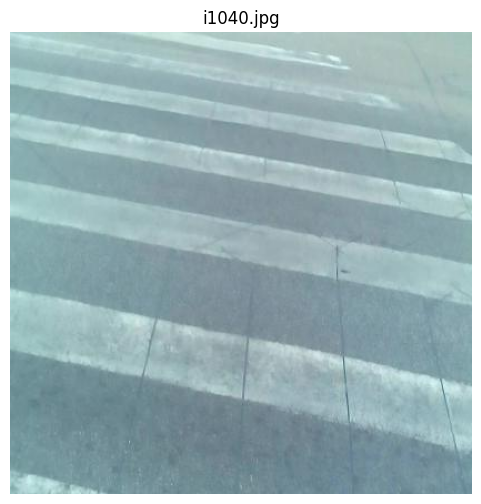

In [ ]:
### ===== 看看隨機樣本與標註檔內容 =====
IMG_DIR = os.path.join(DATASET_ROOT, "images")
LBL_DIR = os.path.join(DATASET_ROOT, "labels")

sample_img = random.choice(glob(f"/kaggle/input/road-detection-imgs-and-labels/dataset/test/images/i1040.jpg", recursive=True))
sample_lbl = sample_img.replace("images", "labels").rsplit(".", 1)[0] + ".txt"

print("Label file:", sample_lbl)
print(open(sample_lbl).read())

plt.figure(figsize=(6,6))
plt.imshow(Image.open(sample_img))
plt.axis('off'); plt.title(os.path.basename(sample_img))
plt.show()


In [ ]:
import os
import shutil
import random
from collections import defaultdict, Counter

# 原始路徑
root_path = '/content/kaggle/input/road-detection-imgs-and-labels/dataset'
src_img_dir = os.path.join(root_path, 'train/images')
src_label_dir = os.path.join(root_path, 'train/labels')

# 目標路徑
dst_img_dir = '/content/train_balanced/images'
dst_label_dir = '/content/train_balanced/labels'
os.makedirs(dst_img_dir, exist_ok=True)
os.makedirs(dst_label_dir, exist_ok=True)

samples_per_class = 71
img_extensions = ['.jpg', '.png', '.jpeg']  # 支援的影像副檔名

# 儲存符合每個類別的樣本 (label, image) 組合
class_to_files = defaultdict(list)

def find_corresponding_image(label_file):
    base_name = os.path.splitext(label_file)[0]
    for ext in img_extensions:
        candidate = os.path.join(src_img_dir, base_name + ext)
        if os.path.exists(candidate):
            return base_name + ext
    return None

# 建立 class → (label, image) 對應表
for label_file in os.listdir(src_label_dir):
    if not label_file.endswith('.txt'):
        continue

    img_file = find_corresponding_image(label_file)
    if img_file is None:
        continue

    label_path = os.path.join(src_label_dir, label_file)
    with open(label_path, 'r') as f:
        lines = f.readlines()
    classes = set([line.strip().split()[0] for line in lines])

    for cls in classes:
        class_to_files[cls].append((label_file, img_file))

# 選取樣本，並記錄實際複製數
selected_files = set()
class_sample_counter = Counter()

for cls, file_pairs in class_to_files.items():
    if len(file_pairs) < samples_per_class:
        sampled = random.choices(file_pairs, k=samples_per_class)
    else:
        sampled = random.sample(file_pairs, samples_per_class)

    for pair in sampled:
        if pair not in selected_files:
            class_sample_counter[cls] += 1
        selected_files.add(pair)

# 複製檔案
for label_file, img_file in selected_files:
    shutil.copy2(os.path.join(src_label_dir, label_file),
                 os.path.join(dst_label_dir, label_file))
    shutil.copy2(os.path.join(src_img_dir, img_file),
                 os.path.join(dst_img_dir, img_file))

# 顯示結果
print(f"✅ 資料處理完成，共複製了 {len(selected_files)} 筆樣本。\n")
print("📊 每個類別實際成功複製的樣本數：")
for cls in sorted(class_sample_counter.keys(), key=lambda x: int(x)):
    print(f"Class {cls}: {class_sample_counter[cls]} samples")


✅ 資料處理完成，共複製了 539 筆樣本。

📊 每個類別實際成功複製的樣本數：
Class 0: 55 samples
Class 1: 63 samples
Class 2: 71 samples
Class 3: 63 samples
Class 4: 71 samples
Class 5: 37 samples
Class 6: 49 samples
Class 7: 71 samples
Class 8: 59 samples


In [ ]:
from ultralytics import YOLO

# 載入模型（使用 yolov8n 也可以換 yolov8s、m、l、x）
model = YOLO("yolov8n.pt")

# 設定 YAML 檔路徑（你自己改好的那個）
yaml_path = "/content/drive/MyDrive/Colab Notebooks/dataset.yaml"  # 請依你的實際位置填

# 開始訓練
model.train(
    data=yaml_path,
    epochs=200,
    imgsz=640,
    batch=16,
    project="road_detection",
    name="yolov8l_custom",
    pretrained=True
)


100%|██████████| 6.25M/6.25M [00:00<00:00, 125MB/s]


Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8l_custom, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, 

100%|██████████| 755k/755k [00:00<00:00, 25.6MB/s]

Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,012,603 parameters, 3,012,587 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 106MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1811.9±888.5 MB/s, size: 130.2 KB)


train: Scanning /content/train_balanced/labels... 539 images, 0 backgrounds, 0 corrupt: 100%|██████████| 539/539 [00:00<00:00, 1490.43it/s]

train: New cache created: /content/train_balanced/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 55.6±11.6 MB/s, size: 232.6 KB)


val: Scanning /content/kaggle/input/road-detection-imgs-and-labels/dataset/val/labels... 158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 158/158 [00:01<00:00, 151.60it/s]

WARNING ⚠️ val: Cache directory /content/kaggle/input/road-detection-imgs-and-labels/dataset/val is not writeable, cache not saved.


Plotting labels to road_detection/yolov8l_custom/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to road_detection/yolov8l_custom
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.33G      1.506      3.326      1.197        133        640: 100%|██████████| 34/34 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        158        794    0.00926      0.772      0.389      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.74G      1.531      1.936      1.201         79        640: 100%|██████████| 34/34 [00:11<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]

                   all        158        794      0.787      0.324      0.559      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.76G      1.512       1.61      1.191        122        640: 100%|██████████| 34/34 [00:10<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

                   all        158        794      0.578      0.559      0.625       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.78G      1.481      1.458      1.175         98        640: 100%|██████████| 34/34 [00:10<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

                   all        158        794      0.535      0.627      0.627      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200       2.8G      1.432      1.426      1.184        101        640: 100%|██████████| 34/34 [00:09<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

                   all        158        794      0.757      0.563      0.618        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.81G      1.429       1.38      1.158        124        640: 100%|██████████| 34/34 [00:09<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        158        794      0.671      0.616       0.67      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.83G      1.418      1.305      1.159         54        640: 100%|██████████| 34/34 [00:09<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        158        794      0.713      0.631      0.707      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.85G      1.384      1.305      1.165        164        640: 100%|██████████| 34/34 [00:10<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]

                   all        158        794      0.663      0.682      0.707      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.86G      1.411      1.205      1.151         94        640: 100%|██████████| 34/34 [00:10<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


                   all        158        794      0.687      0.702      0.721      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.88G      1.381      1.178       1.15        102        640: 100%|██████████| 34/34 [00:10<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        158        794      0.777      0.666       0.75      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200       2.9G      1.354      1.162      1.134         91        640: 100%|██████████| 34/34 [00:10<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

                   all        158        794      0.712      0.709      0.743      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.91G      1.372      1.156      1.144         72        640: 100%|██████████| 34/34 [00:10<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


                   all        158        794      0.679      0.695      0.744      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.93G      1.351      1.118       1.13        183        640: 100%|██████████| 34/34 [00:10<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


                   all        158        794      0.749      0.721      0.769      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.95G      1.324      1.084      1.107         83        640: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        158        794      0.824      0.723      0.771      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.96G      1.335      1.073      1.132        108        640: 100%|██████████| 34/34 [00:09<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        158        794      0.806      0.745      0.793      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.98G      1.319      1.059      1.124         85        640: 100%|██████████| 34/34 [00:09<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]

                   all        158        794      0.789      0.784      0.813      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200         3G      1.328      1.018      1.123         90        640: 100%|██████████| 34/34 [00:10<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        158        794      0.824      0.779       0.82      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      3.02G      1.302      1.025      1.125        136        640: 100%|██████████| 34/34 [00:10<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        158        794       0.73      0.751       0.76      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      3.03G      1.317      0.981      1.117        125        640: 100%|██████████| 34/34 [00:10<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


                   all        158        794      0.849      0.772      0.803      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.05G      1.317     0.9784      1.121        172        640: 100%|██████████| 34/34 [00:10<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        158        794      0.874      0.746      0.793      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      3.07G      1.314     0.9757      1.107        218        640: 100%|██████████| 34/34 [00:11<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        158        794      0.839      0.755      0.824      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      3.25G      1.275     0.9277      1.102        158        640: 100%|██████████| 34/34 [00:10<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        158        794      0.824      0.753      0.805      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      3.27G      1.276     0.9409        1.1         99        640: 100%|██████████| 34/34 [00:09<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        158        794      0.817      0.753      0.799      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      3.29G       1.27     0.9182      1.107         70        640: 100%|██████████| 34/34 [00:09<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        158        794      0.829      0.755      0.814      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200       3.3G      1.277     0.9108      1.089        123        640: 100%|██████████| 34/34 [00:09<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        158        794      0.771      0.737      0.797      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      3.32G      1.238     0.9003      1.094         90        640: 100%|██████████| 34/34 [00:10<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        158        794      0.819      0.771      0.813      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      3.34G       1.27     0.8727      1.106         74        640: 100%|██████████| 34/34 [00:10<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


                   all        158        794      0.834      0.749       0.82       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      3.36G      1.235     0.8712      1.082         57        640: 100%|██████████| 34/34 [00:10<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

                   all        158        794      0.821       0.82      0.837      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      3.37G      1.237     0.8894      1.098        122        640: 100%|██████████| 34/34 [00:10<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

                   all        158        794      0.807       0.74      0.808      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      3.39G      1.274      0.862      1.099        144        640: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

                   all        158        794       0.87       0.78      0.824      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      3.41G      1.249     0.8717      1.089         44        640: 100%|██████████| 34/34 [00:10<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

                   all        158        794      0.821      0.773       0.84      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      3.42G      1.228     0.8606      1.088        147        640: 100%|██████████| 34/34 [00:09<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

                   all        158        794      0.849      0.739       0.82      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      3.44G      1.244      0.832       1.09        108        640: 100%|██████████| 34/34 [00:09<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all        158        794      0.819      0.752      0.842      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      3.46G      1.222     0.8234      1.079         99        640: 100%|██████████| 34/34 [00:09<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        158        794       0.75      0.796      0.813      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      3.48G      1.211      0.815      1.086         76        640: 100%|██████████| 34/34 [00:10<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]

                   all        158        794      0.854      0.756      0.823      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      3.49G      1.211     0.8218      1.072         87        640: 100%|██████████| 34/34 [00:10<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


                   all        158        794      0.835      0.812      0.852       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      3.51G      1.272     0.8445      1.102        140        640: 100%|██████████| 34/34 [00:10<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        158        794      0.817      0.757      0.826      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      3.53G      1.244     0.8234      1.097         49        640: 100%|██████████| 34/34 [00:10<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        158        794      0.885        0.8      0.855      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      3.54G      1.212     0.8058      1.086        151        640: 100%|██████████| 34/34 [00:10<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        158        794      0.846      0.809      0.864      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      3.56G      1.212     0.7908      1.065        116        640: 100%|██████████| 34/34 [00:10<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        158        794      0.846      0.754      0.834      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      3.58G      1.199     0.7819      1.076        126        640: 100%|██████████| 34/34 [00:09<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        158        794      0.842      0.786      0.852      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200       3.6G      1.209     0.7888      1.074        153        640: 100%|██████████| 34/34 [00:09<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        158        794      0.771      0.809      0.845      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      3.61G       1.21     0.7737      1.078         84        640: 100%|██████████| 34/34 [00:09<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        158        794      0.865      0.769       0.85        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      3.63G      1.208     0.7842      1.074        137        640: 100%|██████████| 34/34 [00:10<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        158        794      0.735      0.792      0.802      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      3.65G      1.223     0.7857      1.079         78        640: 100%|██████████| 34/34 [00:10<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        158        794      0.852      0.773      0.825      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      3.66G      1.168     0.7624      1.063        131        640: 100%|██████████| 34/34 [00:10<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


                   all        158        794      0.809      0.793       0.83      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      3.68G      1.205     0.7845      1.067         60        640: 100%|██████████| 34/34 [00:10<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

                   all        158        794      0.856      0.756      0.832      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200       3.7G      1.147      0.736      1.048        151        640: 100%|██████████| 34/34 [00:10<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        158        794      0.822      0.797       0.84      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      3.71G      1.159     0.7445       1.06         90        640: 100%|██████████| 34/34 [00:10<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]

                   all        158        794      0.826      0.786       0.84      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      3.73G      1.181     0.7509      1.058         78        640: 100%|██████████| 34/34 [00:09<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        158        794      0.874      0.777      0.834      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      3.75G      1.173     0.7435      1.068        125        640: 100%|██████████| 34/34 [00:09<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all        158        794      0.793      0.803      0.849      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      3.77G      1.134     0.7436      1.048        200        640: 100%|██████████| 34/34 [00:09<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

                   all        158        794      0.799      0.786      0.831      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      3.78G      1.221     0.7495      1.072        115        640: 100%|██████████| 34/34 [00:10<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]

                   all        158        794      0.877      0.813      0.855      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200       3.8G      1.157     0.7274      1.047         86        640: 100%|██████████| 34/34 [00:10<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        158        794      0.803      0.791      0.828      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      3.82G      1.149     0.7325      1.053        134        640: 100%|██████████| 34/34 [00:10<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        158        794      0.768      0.797      0.832      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      3.83G      1.153     0.7209      1.053        149        640: 100%|██████████| 34/34 [00:11<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


                   all        158        794      0.838      0.782      0.848      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      3.85G      1.151      0.717      1.055        133        640: 100%|██████████| 34/34 [00:10<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        158        794      0.846      0.749      0.832      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      3.87G      1.174     0.7223      1.054         92        640: 100%|██████████| 34/34 [00:10<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all        158        794       0.87      0.772      0.834      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      3.88G      1.157     0.6972      1.045        124        640: 100%|██████████| 34/34 [00:09<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]

                   all        158        794      0.867      0.771      0.843      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200       3.9G      1.124     0.6857      1.045        133        640: 100%|██████████| 34/34 [00:09<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]

                   all        158        794      0.835      0.791      0.845      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      3.92G      1.155     0.7105      1.054        102        640: 100%|██████████| 34/34 [00:10<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        158        794      0.787      0.827      0.816       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      3.94G      1.132     0.6985      1.044        104        640: 100%|██████████| 34/34 [00:10<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        158        794      0.838      0.807      0.837      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      3.95G      1.106     0.6938      1.036        102        640: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        158        794      0.866      0.784      0.844      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      3.97G       1.08     0.6816      1.019         98        640: 100%|██████████| 34/34 [00:11<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


                   all        158        794      0.899      0.784      0.853      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      3.99G      1.118     0.6858      1.037        102        640: 100%|██████████| 34/34 [00:10<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        158        794      0.823      0.753      0.814      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200         4G      1.123     0.6743      1.034        129        640: 100%|██████████| 34/34 [00:11<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


                   all        158        794      0.836      0.798      0.834      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      4.02G      1.094     0.6658       1.03        145        640: 100%|██████████| 34/34 [00:10<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]

                   all        158        794       0.89      0.745      0.828      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      4.04G      1.115     0.6826      1.045         74        640: 100%|██████████| 34/34 [00:09<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        158        794      0.831      0.809      0.835      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      4.06G      1.105      0.684      1.039         80        640: 100%|██████████| 34/34 [00:09<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

                   all        158        794      0.825      0.781      0.838      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      4.07G       1.11     0.6682      1.024        115        640: 100%|██████████| 34/34 [00:09<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        158        794      0.847       0.78      0.845      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      4.09G      1.138     0.6799      1.039         95        640: 100%|██████████| 34/34 [00:10<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

                   all        158        794      0.887      0.793      0.865      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      4.11G      1.097     0.6664      1.038         77        640: 100%|██████████| 34/34 [00:10<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        158        794      0.864      0.793      0.859      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      4.12G      1.117     0.6682      1.038        107        640: 100%|██████████| 34/34 [00:10<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

                   all        158        794      0.825      0.811      0.848      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      4.14G      1.132     0.6657      1.045         84        640: 100%|██████████| 34/34 [00:11<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

                   all        158        794      0.855      0.779      0.853      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      4.16G       1.08     0.6555      1.026        104        640: 100%|██████████| 34/34 [00:10<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        158        794      0.883      0.779      0.853      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      4.18G      1.111     0.6802      1.041         75        640: 100%|██████████| 34/34 [00:10<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all        158        794      0.812      0.781      0.836      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      4.19G      1.086     0.6558      1.037        138        640: 100%|██████████| 34/34 [00:09<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        158        794       0.84      0.781      0.841      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      4.21G      1.099     0.6627      1.024        122        640: 100%|██████████| 34/34 [00:09<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]

                   all        158        794      0.874      0.773      0.836        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      4.23G      1.075     0.6512      1.023        106        640: 100%|██████████| 34/34 [00:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


                   all        158        794      0.854      0.794      0.852      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      4.24G      1.049      0.623      1.002        138        640: 100%|██████████| 34/34 [00:10<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        158        794      0.813      0.819      0.846      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      4.26G      1.084      0.633      1.022         94        640: 100%|██████████| 34/34 [00:10<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        158        794      0.894      0.767      0.835      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      4.28G      1.076     0.6346       1.02        142        640: 100%|██████████| 34/34 [00:10<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

                   all        158        794      0.861      0.795      0.845        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      4.29G      1.099     0.6349      1.028        101        640: 100%|██████████| 34/34 [00:10<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


                   all        158        794      0.876      0.765      0.827      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      4.31G      1.076     0.6334      1.019         80        640: 100%|██████████| 34/34 [00:11<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

                   all        158        794      0.889      0.767      0.838      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      4.33G      1.051      0.618      1.007         76        640: 100%|██████████| 34/34 [00:11<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        158        794      0.851      0.775      0.835      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      4.35G      1.077     0.6331      1.014        101        640: 100%|██████████| 34/34 [00:10<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

                   all        158        794      0.889       0.76      0.843      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      4.36G      1.063     0.6295      1.012         80        640: 100%|██████████| 34/34 [00:09<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        158        794      0.874       0.75      0.824      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      4.38G      1.032     0.6133      1.009        153        640: 100%|██████████| 34/34 [00:09<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

                   all        158        794      0.857      0.755      0.835      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200       4.4G      1.084     0.6266      1.025        138        640: 100%|██████████| 34/34 [00:10<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        158        794      0.793       0.83      0.835      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      4.41G      1.059     0.6251      1.005        160        640: 100%|██████████| 34/34 [00:10<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

                   all        158        794       0.83      0.811      0.832      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      4.43G      1.058     0.6236      1.012        108        640: 100%|██████████| 34/34 [00:10<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


                   all        158        794      0.859      0.792      0.835        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      4.45G      1.054     0.6186      1.012         62        640: 100%|██████████| 34/34 [00:11<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        158        794      0.888      0.786      0.839      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      4.47G      1.018     0.6075     0.9933         85        640: 100%|██████████| 34/34 [00:10<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]

                   all        158        794       0.88      0.809      0.862      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      4.48G      1.021     0.6026      1.005        147        640: 100%|██████████| 34/34 [00:11<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        158        794      0.852      0.794      0.842      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200       4.5G      1.053     0.6095      1.007         69        640: 100%|██████████| 34/34 [00:11<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        158        794      0.873      0.804       0.84      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      4.52G      1.014     0.5846     0.9939         39        640: 100%|██████████| 34/34 [00:11<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        158        794      0.884      0.819      0.853      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      4.54G      1.018     0.5998     0.9984         59        640: 100%|██████████| 34/34 [00:09<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        158        794      0.867      0.807      0.854      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      4.55G      1.033     0.6014     0.9988        233        640: 100%|██████████| 34/34 [00:09<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        158        794      0.865      0.808      0.856      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      4.57G      1.009     0.5995     0.9929         46        640: 100%|██████████| 34/34 [00:09<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        158        794      0.864      0.827      0.852      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      4.59G      1.029     0.5827      1.004        107        640: 100%|██████████| 34/34 [00:10<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        158        794      0.881      0.784      0.857      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200       4.6G      1.026     0.5852     0.9966        182        640: 100%|██████████| 34/34 [00:10<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


                   all        158        794      0.882      0.794      0.856      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      4.62G      0.986     0.5747     0.9779        157        640: 100%|██████████| 34/34 [00:10<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]

                   all        158        794      0.896      0.784      0.855      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      4.64G      1.007     0.5886     0.9871        105        640: 100%|██████████| 34/34 [00:10<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        158        794      0.844      0.798      0.855      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      4.65G      1.017     0.5803     0.9976        134        640: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

                   all        158        794      0.866      0.804      0.856       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      4.67G     0.9894     0.5689     0.9857        111        640: 100%|██████████| 34/34 [00:10<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        158        794      0.872      0.819      0.858      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      4.69G      1.025     0.5881     0.9842        110        640: 100%|██████████| 34/34 [00:09<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        158        794      0.879      0.805       0.85      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      4.71G       1.01     0.5791     0.9901         78        640: 100%|██████████| 34/34 [00:09<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        158        794      0.867      0.809      0.849      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      4.72G      1.018      0.593      1.004        132        640: 100%|██████████| 34/34 [00:09<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

                   all        158        794      0.881      0.817       0.85       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      4.74G     0.9879     0.5707     0.9918        111        640: 100%|██████████| 34/34 [00:10<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        158        794      0.846       0.81      0.858       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      4.76G      1.011     0.5852     0.9903        148        640: 100%|██████████| 34/34 [00:10<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


                   all        158        794      0.859      0.817      0.855      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      4.77G     0.9886     0.5795     0.9839        113        640: 100%|██████████| 34/34 [00:10<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


                   all        158        794      0.891      0.797      0.857       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      4.79G     0.9882     0.5625     0.9724         69        640: 100%|██████████| 34/34 [00:10<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        158        794      0.896      0.782       0.85      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      4.81G     0.9699     0.5636     0.9786        113        640: 100%|██████████| 34/34 [00:10<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

                   all        158        794      0.866      0.792      0.842      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      4.83G     0.9904     0.5601     0.9802         99        640: 100%|██████████| 34/34 [00:10<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        158        794      0.873       0.82      0.845      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      4.84G     0.9614     0.5606     0.9764        101        640: 100%|██████████| 34/34 [00:10<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        158        794      0.893      0.781      0.847      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      4.86G       0.98     0.5686     0.9835        121        640: 100%|██████████| 34/34 [00:09<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all        158        794      0.873      0.793      0.855      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      4.88G     0.9594      0.569     0.9651        168        640: 100%|██████████| 34/34 [00:09<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]

                   all        158        794      0.894      0.787      0.847      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      4.89G      0.969     0.5593     0.9699        105        640: 100%|██████████| 34/34 [00:10<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

                   all        158        794      0.869      0.807      0.859      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      4.91G     0.9621     0.5547     0.9722         78        640: 100%|██████████| 34/34 [00:10<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


                   all        158        794      0.841      0.818      0.857      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      4.93G     0.9636     0.5553     0.9751         63        640: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


                   all        158        794      0.864      0.813      0.853      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      4.94G     0.9516     0.5466      0.966         70        640: 100%|██████████| 34/34 [00:10<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

                   all        158        794      0.855      0.841      0.876      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      4.96G     0.9455     0.5505      0.971        103        640: 100%|██████████| 34/34 [00:10<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        158        794      0.873      0.796      0.858      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      4.98G     0.9433     0.5464     0.9632         95        640: 100%|██████████| 34/34 [00:10<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


                   all        158        794      0.859      0.847      0.858      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      4.99G     0.9317     0.5426      0.972         77        640: 100%|██████████| 34/34 [00:09<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

                   all        158        794      0.855      0.824      0.849      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      5.01G     0.9547     0.5562     0.9696         40        640: 100%|██████████| 34/34 [00:09<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all        158        794      0.836      0.825      0.851        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      5.03G     0.9401     0.5409     0.9569         95        640: 100%|██████████| 34/34 [00:09<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


                   all        158        794      0.875      0.812      0.862      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      5.05G     0.9376     0.5429     0.9651        121        640: 100%|██████████| 34/34 [00:10<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        158        794      0.867      0.831      0.859      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      5.06G     0.9188       0.53     0.9519        101        640: 100%|██████████| 34/34 [00:10<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]

                   all        158        794      0.889        0.8      0.842      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      5.08G     0.9249     0.5373      0.958        142        640: 100%|██████████| 34/34 [00:10<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

                   all        158        794      0.836      0.854      0.856      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200       5.1G     0.9252     0.5238     0.9593        100        640: 100%|██████████| 34/34 [00:11<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        158        794      0.898      0.838      0.858      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      5.12G     0.9198     0.5286     0.9594         78        640: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        158        794      0.896      0.806      0.855      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      5.13G     0.9715     0.5402     0.9649        157        640: 100%|██████████| 34/34 [00:10<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


                   all        158        794      0.893      0.792      0.858      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      5.15G     0.9365     0.5341      0.963        122        640: 100%|██████████| 34/34 [00:09<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        158        794      0.852      0.823      0.857      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      5.17G     0.9492     0.5415     0.9649         70        640: 100%|██████████| 34/34 [00:09<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        158        794      0.847      0.797      0.851      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      5.18G     0.9293     0.5242     0.9636         86        640: 100%|██████████| 34/34 [00:09<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

                   all        158        794      0.871      0.801      0.857      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200       5.2G     0.9291      0.528     0.9658        114        640: 100%|██████████| 34/34 [00:10<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


                   all        158        794      0.874      0.803      0.858      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      5.22G     0.9301     0.5275     0.9572        100        640: 100%|██████████| 34/34 [00:10<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        158        794       0.84      0.832      0.867      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      5.45G     0.9173      0.523     0.9573        157        640: 100%|██████████| 34/34 [00:10<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        158        794      0.841      0.834      0.856      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      5.46G     0.9186     0.5267     0.9552         87        640: 100%|██████████| 34/34 [00:10<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        158        794      0.857      0.822      0.851      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      5.48G     0.9023      0.521     0.9574        156        640: 100%|██████████| 34/34 [00:10<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

                   all        158        794      0.891       0.81      0.851      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200       5.5G     0.8976     0.5104     0.9566        122        640: 100%|██████████| 34/34 [00:10<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

                   all        158        794      0.895      0.805      0.853      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      5.51G     0.8777     0.5117     0.9501        121        640: 100%|██████████| 34/34 [00:10<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

                   all        158        794      0.902      0.817      0.856      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      5.53G     0.8857      0.508     0.9416         67        640: 100%|██████████| 34/34 [00:09<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

                   all        158        794      0.912      0.801      0.852      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      5.55G     0.9255     0.5271     0.9573         76        640: 100%|██████████| 34/34 [00:09<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        158        794      0.904      0.801       0.85       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      5.56G     0.8984     0.5078     0.9441         97        640: 100%|██████████| 34/34 [00:10<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


                   all        158        794      0.881      0.823      0.847      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      5.58G     0.8923     0.5182     0.9507        105        640: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        158        794       0.88      0.818      0.855       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200       5.6G     0.8943     0.5081     0.9445        158        640: 100%|██████████| 34/34 [00:10<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

                   all        158        794      0.873      0.836      0.866      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      5.62G     0.8619     0.4909     0.9464        129        640: 100%|██████████| 34/34 [00:10<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


                   all        158        794      0.861       0.83      0.861      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      5.63G     0.8864      0.506     0.9419        115        640: 100%|██████████| 34/34 [00:11<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


                   all        158        794      0.853      0.829      0.868      0.631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      5.65G     0.8619     0.4941     0.9377        118        640: 100%|██████████| 34/34 [00:11<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        158        794      0.834      0.828      0.864      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      5.67G     0.9036     0.5142     0.9533        141        640: 100%|██████████| 34/34 [00:10<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


                   all        158        794      0.843      0.821       0.86      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      5.68G     0.9078      0.512     0.9568        131        640: 100%|██████████| 34/34 [00:09<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

                   all        158        794      0.848      0.819      0.856      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200       5.7G     0.8907     0.5112     0.9393        117        640: 100%|██████████| 34/34 [00:09<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all        158        794      0.814      0.839      0.861      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      5.72G     0.8977     0.5067     0.9501         83        640: 100%|██████████| 34/34 [00:09<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        158        794       0.87      0.826      0.862      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      5.74G     0.8848     0.5036     0.9419         94        640: 100%|██████████| 34/34 [00:10<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


                   all        158        794      0.897      0.815      0.863      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      5.75G     0.8599     0.4992     0.9489        154        640: 100%|██████████| 34/34 [00:11<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

                   all        158        794      0.903      0.813      0.865      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      5.77G     0.8571     0.4914     0.9389         67        640: 100%|██████████| 34/34 [00:10<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        158        794      0.857      0.822       0.86      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      5.79G     0.8739     0.5031     0.9423         92        640: 100%|██████████| 34/34 [00:10<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]

                   all        158        794      0.877      0.817      0.864      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200       5.8G     0.8608     0.4987     0.9391        226        640: 100%|██████████| 34/34 [00:10<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

                   all        158        794      0.894      0.795      0.858      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      5.82G     0.8921     0.5033     0.9437         93        640: 100%|██████████| 34/34 [00:10<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]

                   all        158        794      0.921      0.791      0.857      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      5.84G     0.8737     0.5008     0.9414        155        640: 100%|██████████| 34/34 [00:09<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

                   all        158        794      0.896      0.807      0.862      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      5.86G     0.8601     0.4918      0.934        100        640: 100%|██████████| 34/34 [00:08<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        158        794       0.84      0.832      0.865      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      5.87G     0.8552     0.4883     0.9344         87        640: 100%|██████████| 34/34 [00:10<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


                   all        158        794      0.889      0.817      0.864      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      5.89G      0.852     0.4888     0.9355         91        640: 100%|██████████| 34/34 [00:10<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]

                   all        158        794      0.897      0.819      0.861      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      5.91G     0.8558     0.4836     0.9363         83        640: 100%|██████████| 34/34 [00:10<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        158        794      0.918      0.816      0.863      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      5.92G     0.8171      0.477     0.9272        160        640: 100%|██████████| 34/34 [00:10<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]


                   all        158        794      0.909      0.813      0.871      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      5.94G      0.867      0.494     0.9376         81        640: 100%|██████████| 34/34 [00:10<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        158        794      0.897      0.821      0.858      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      5.96G     0.8305     0.4844     0.9282        130        640: 100%|██████████| 34/34 [00:10<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


                   all        158        794      0.897      0.814      0.861      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      5.97G      0.858     0.4938     0.9457        203        640: 100%|██████████| 34/34 [00:09<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        158        794      0.886      0.824      0.867      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      5.99G     0.8511     0.4844     0.9356         98        640: 100%|██████████| 34/34 [00:08<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        158        794      0.895      0.816      0.867      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      6.01G     0.8385     0.4839     0.9317        135        640: 100%|██████████| 34/34 [00:09<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        158        794      0.893      0.832      0.866      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      6.03G     0.8248      0.476     0.9352         87        640: 100%|██████████| 34/34 [00:10<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


                   all        158        794      0.896      0.821      0.864       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      6.04G      0.826     0.4768     0.9292        117        640: 100%|██████████| 34/34 [00:10<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        158        794      0.867      0.825      0.862      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      6.06G     0.8498     0.4826     0.9304         74        640: 100%|██████████| 34/34 [00:10<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        158        794      0.886      0.813      0.862      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      6.08G     0.8279     0.4679     0.9286         59        640: 100%|██████████| 34/34 [00:10<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


                   all        158        794      0.848      0.826      0.855      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      6.09G     0.8319     0.4778     0.9374        112        640: 100%|██████████| 34/34 [00:10<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        158        794      0.883      0.806      0.848      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      6.11G     0.8392      0.476     0.9265        144        640: 100%|██████████| 34/34 [00:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

                   all        158        794      0.858      0.823      0.849      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      6.13G     0.8401     0.4815     0.9312         87        640: 100%|██████████| 34/34 [00:09<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

                   all        158        794      0.832      0.842      0.857      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      6.14G     0.8068      0.464     0.9327        128        640: 100%|██████████| 34/34 [00:09<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        158        794      0.874      0.816       0.86      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      6.16G     0.8238      0.476     0.9335        139        640: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

                   all        158        794      0.886      0.826      0.858      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      6.18G     0.8078     0.4756     0.9267        115        640: 100%|██████████| 34/34 [00:10<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


                   all        158        794      0.896      0.819      0.858       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200       6.2G     0.8206     0.4705     0.9283        107        640: 100%|██████████| 34/34 [00:10<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

                   all        158        794      0.892      0.813      0.862      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      6.21G     0.8608     0.4827     0.9367        158        640: 100%|██████████| 34/34 [00:11<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        158        794      0.842      0.857      0.862      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      6.23G     0.8318     0.4751     0.9223        146        640: 100%|██████████| 34/34 [00:11<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

                   all        158        794      0.855      0.834       0.86      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      6.25G     0.8098       0.46     0.9272         80        640: 100%|██████████| 34/34 [00:11<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        158        794      0.861      0.847      0.864      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      6.27G       0.82     0.4699     0.9223        165        640: 100%|██████████| 34/34 [00:10<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

                   all        158        794      0.862      0.847      0.866       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      6.28G     0.8191     0.4635     0.9175        125        640: 100%|██████████| 34/34 [00:10<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        158        794      0.852      0.853      0.864       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200       6.3G     0.8164     0.4637     0.9272        117        640: 100%|██████████| 34/34 [00:09<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        158        794      0.865      0.844      0.863      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      6.32G     0.7922     0.4567     0.9193         63        640: 100%|██████████| 34/34 [00:10<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        158        794      0.845      0.841       0.86      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      6.33G      0.812     0.4639      0.914        108        640: 100%|██████████| 34/34 [00:10<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        158        794      0.843      0.845       0.86      0.622


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      6.35G     0.8245     0.4561     0.9199         25        640: 100%|██████████| 34/34 [00:12<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        158        794      0.867      0.815      0.859      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      6.37G     0.8168     0.4499     0.9071         55        640: 100%|██████████| 34/34 [00:09<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]

                   all        158        794      0.871      0.817       0.86       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      6.38G     0.8037     0.4357     0.9114         36        640: 100%|██████████| 34/34 [00:10<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        158        794      0.879      0.803      0.857      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200       6.4G     0.7875     0.4286     0.9098         82        640: 100%|██████████| 34/34 [00:10<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        158        794      0.896      0.803      0.859      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      6.42G     0.7998     0.4367     0.9083        104        640: 100%|██████████| 34/34 [00:10<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

                   all        158        794      0.881      0.811      0.859      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      6.44G     0.7869     0.4305     0.9023         94        640: 100%|██████████| 34/34 [00:10<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

                   all        158        794      0.871      0.814       0.86      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      6.45G     0.7921     0.4277     0.9113         72        640: 100%|██████████| 34/34 [00:10<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        158        794      0.827      0.855      0.862      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      6.47G     0.7757      0.423     0.9034         56        640: 100%|██████████| 34/34 [00:10<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]

                   all        158        794      0.897      0.795      0.864      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      6.49G     0.7779     0.4228     0.9048         85        640: 100%|██████████| 34/34 [00:09<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        158        794      0.899      0.794      0.865      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200       6.5G     0.7813     0.4238     0.8975         52        640: 100%|██████████| 34/34 [00:09<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        158        794        0.9      0.797      0.862      0.627



200 epochs completed in 0.713 hours.
Optimizer stripped from road_detection/yolov8l_custom/weights/last.pt, 6.3MB
Optimizer stripped from road_detection/yolov8l_custom/weights/best.pt, 6.3MB

Validating road_detection/yolov8l_custom/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


                   all        158        794      0.909      0.812      0.871      0.634
   Trafic Light Signal          8         16      0.964      0.688      0.734      0.493
           Stop Signal          8          8      0.847          1      0.926      0.819
     Speedlimit Signal         67         71      0.986      0.993      0.994      0.894
      Crosswalk Signal         17         21      0.942       0.78      0.847      0.683
             Crosswalk         17         18      0.926      0.889      0.893      0.628
            Pedestrian         10         29      0.888      0.759      0.861      0.563
                   Bus          8          9      0.826      0.778      0.854      0.628
                   Car         45        407      0.924       0.66      0.856      0.478
                 Truck         43        215      0.875      0.763      0.869      0.517
Speed: 0.3ms preprocess, 3.8ms inference, 0.0ms loss, 7.4ms postprocess per image
Results saved to road_detect

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a1376e969d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0470

In [ ]:
### ===== 驗證集指標 =====
metrics = model.val()
print(metrics)   # mAP50-95、Precision、Recall...


Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 271.6±238.1 MB/s, size: 112.0 KB)


val: Scanning /content/kaggle/input/road-detection-imgs-and-labels/dataset/val/labels... 158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 158/158 [00:00<00:00, 530.17it/s]

WARNING ⚠️ val: Cache directory /content/kaggle/input/road-detection-imgs-and-labels/dataset/val is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


                   all        158        794      0.908      0.813      0.871      0.634
   Trafic Light Signal          8         16      0.965      0.688      0.736      0.494
           Stop Signal          8          8      0.847          1      0.926       0.82
     Speedlimit Signal         67         71      0.986      0.993      0.994      0.886
      Crosswalk Signal         17         21      0.943      0.782       0.85      0.688
             Crosswalk         17         18      0.926      0.889      0.894      0.629
            Pedestrian         10         29      0.888      0.759      0.859      0.563
                   Bus          8          9      0.824      0.778      0.862      0.639
                   Car         45        407      0.928      0.663       0.85      0.471
                 Truck         43        215      0.868      0.767      0.869      0.519
Speed: 2.7ms preprocess, 8.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to road_detect


image 1/1 /content/i1478.jpg: 480x640 1 Bus, 8 Cars, 7 Trucks, 17.7ms
Speed: 5.3ms preprocess, 17.7ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


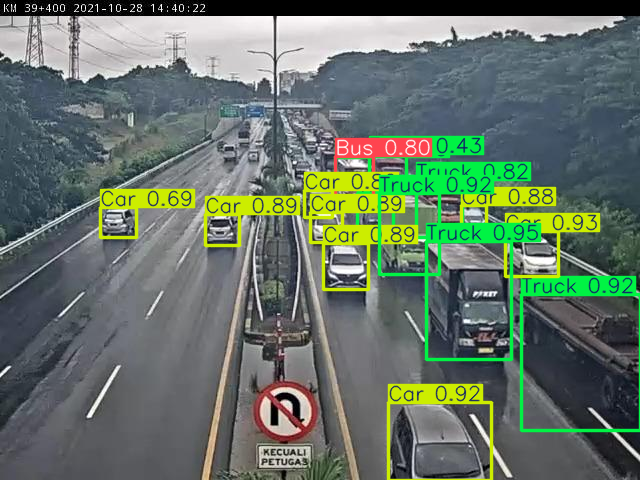

In [ ]:
from IPython.display import Image, display

img_path = "/content/i1478.jpg"

# 推論
results = model.predict(img_path, conf=0.25)

# 顯示圖片
results[0].show()  # 顯示畫出框的圖片


image 1/1 /content/i1478.jpg: 480x640 1 Bus, 8 Cars, 7 Trucks, 18.2ms
Speed: 12.3ms preprocess, 18.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


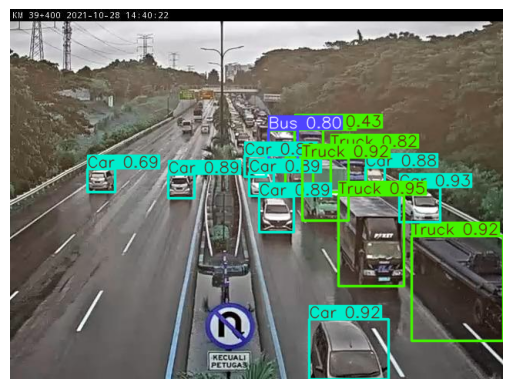

In [ ]:
### ===== 推論並畫框 =====
test_imgs = random.sample(glob(f"/content/i1478.jpg"), 1)

for p in test_imgs:
    res = model.predict(p, conf=0.25, save=False)[0]
    res.plot()               # 直接在 RAM 畫彩圖
    plt.imshow(res.plot())
    plt.axis('off'); plt.show()


In [ ]:
!zip -r road_detection.zip road_detection

  adding: road_detection/ (stored 0%)
  adding: road_detection/yolov8l_custom/ (stored 0%)
  adding: road_detection/yolov8l_custom/val_batch2_pred.jpg (deflated 8%)
  adding: road_detection/yolov8l_custom/val_batch2_labels.jpg (deflated 8%)
  adding: road_detection/yolov8l_custom/val_batch0_pred.jpg (deflated 7%)
  adding: road_detection/yolov8l_custom/train_batch6460.jpg (deflated 9%)
  adding: road_detection/yolov8l_custom/args.yaml (deflated 52%)
  adding: road_detection/yolov8l_custom/val_batch1_labels.jpg (deflated 13%)
  adding: road_detection/yolov8l_custom/P_curve.png (deflated 7%)
  adding: road_detection/yolov8l_custom/train_batch2.jpg (deflated 3%)
  adding: road_detection/yolov8l_custom/confusion_matrix.png (deflated 20%)
  adding: road_detection/yolov8l_custom/PR_curve.png (deflated 11%)
  adding: road_detection/yolov8l_custom/results.csv (deflated 64%)
  adding: road_detection/yolov8l_custom/F1_curve.png (deflated 6%)
  adding: road_detection/yolov8l_custom/val_batch0_lab

In [ ]:
from glob import glob
from collections import Counter

labels = glob("/content/kaggle/input/road-detection-imgs-and-labels/dataset/train/labels/i0.txt")
counter = Counter()

for label_path in labels:
    with open(label_path) as f:
        for line in f:
            class_id = int(line.split()[0])
            counter[class_id] += 1

# 顯示各類別出現次數
for class_id, count in sorted(counter.items()):
    print(f"Class {class_id}: {count} instances")
